# Machine Learning Exercises 7  
Today you will reflect on multiclass classification with K-nearest neighbours and multinomial
logistic regression. Both are examples of machine learning models that directly models the
posterior class probabilities.  
  
## Note on visualising classifiers  
Often it will make sense to make a plot showing either the true class or the predicted class for
each observation in your dataset. More generally, you may wish to make a plot that shows the
classification for any future data point that you could get, so as to visualise how the classification
method assigns a class.  
There are many options for visualising decision boundaries. A basic method is to colour the
feature space according to the prediction that the classifier would make. This works particularly
well for a two-dimensional feature space: Create a suitably fine grid over features, then for each
point on the grid compute the classification and colour the point accordingly.

## K-nearest neighbours

**Exercise 1.** Consider the tiny dataset in Figure 1 or draw a similarly simple one yourself.  
![](ex1.png)  
 
A. Sketch by hand the decision boundaries for 1-nearest neighbour classification.  
B. Give one or more examples of a new observation that under 3-NN would be classified as  
  - (a) *bullet* with a majority of 2 to 1.  
  - (b) *open circle* with a majority of 2 to 1.
  - (c) *open circle* with a majority of 3 to 0.  

C. Describe in terms of pseudocode how the algorithm can be implemented and reflect on the
computational complexity of the method. For instance, consider the conceptually simple
implementation that considers the distance to all training points each time a classification
is made.  
D. Explain why knn is an approximation to the Bayes classifier.  

A.  
![](ex1as.png)  
  
B. (bullet = blue, open circle = red).  
  - (a) (2,6)  
  - (b) (5,2)  
  - (c) (7,4)  
  
C.  
1. Let A=(x,y) be the point to be classified.  
2. Compute the distance from A to every point in the graph.  
3. Sort this list of distances and take the first $K$ elements.
4. Count each class in this sublist. A is classified as the class with the highest count.  
  
D.  
The Bayes classifier assigns each point the class with the highest posterior probability. KNN estimates this probability by finding points similar to the one being classified.  

**Exercise 2.** Now use the two datasets Ex1-training.csv and Ex1-test.csv to build a knn classifier. There are two features ($x_1$ and $x_2$) and three classes (Black = 1, Red = 2, Blue = 3). The training data is seen in Figure 2.  
![](ex2.png)  
  
A. Consider classification by 10-nearest neighbours. Compute the estimated posterior distribution of classes, $\hat{\mathrm{P}}(Y=y|X=(x_1,x_2))$, for a new observation with $(x_1, x_2) = (3, 3.5)$.  
B. Classification by K-nearest neighbours is implemented by method `KNeighborsClassifier`
from `sklearn.neighbors`. Train two classifiers, one based on the 5 nearest neighbours and
the other based on the 10 nearest neighbours. Use the 10-NN classifier to check the result
from A.  
C. Visualise the two classifiers from B. by drawing their decision regions as described above.  
D. For a suitable range of $K$ plot the corresponding training and test errors (this is what
we saw on Figure 2.17 from Introduction to Statistical Learning, where they plot against
“flexibility” 1/K). Describe what you see. Which K would you suggest based on this plot?

In [36]:
# A
import pandas as pd
import numpy as np
from collections import Counter
def manhattan(x1, y1, x2, y2):
    return np.abs(x1 - x2) + np.abs(y1 - y2)

df_train = pd.read_csv('Ex1-training.csv')
X_tr = df_train[['x1', 'x2']].to_numpy()
y_tr = df_train['y'].to_numpy()

def KNN(X: np.ndarray, y: np.ndarray, point: np.ndarray, K: int):
    x1 = point[:,0]
    x2 = point[:,1]
    dists = manhattan(x1, x2, X[:,0], X[:,1])
    top_K = np.argsort(dists)[:K]
    return [(c, v / K) for c, v in Counter(y[top_K]).items()]

point = np.array([[3, 3.5]])
K = 10
probs = KNN(X_tr, y_tr, point, K)
print(f"With K={K} and a point at ({point[0,0]},{point[0,1]}):")
for c, p in probs:
    print(f"Class {c} has a posterior probability of {p}")

With K=10 and a point at (3.0,3.5):
Class 1 has a posterior probability of 0.6
Class 2 has a posterior probability of 0.4


In [37]:
# B
from sklearn.neighbors import KNeighborsClassifier
nei5 = KNeighborsClassifier(n_neighbors=5)
nei5.fit(X_tr, y_tr)
nei10 = KNeighborsClassifier(n_neighbors=10)
nei10.fit(X_tr, y_tr)
pred = nei10.predict_proba(point)
print(pred)
# Something's wrong, I can feel it.

[[0.5 0.5 0. ]]


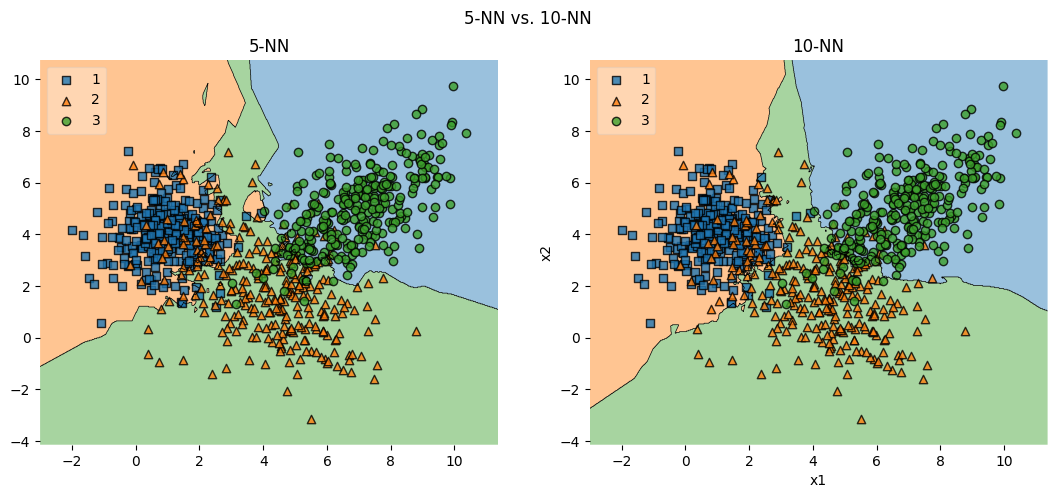

In [49]:
# C
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
plot_decision_regions(X_tr, y_tr, clf=nei5,  legend=2, ax=ax[0], n_jobs=-1)
plot_decision_regions(X_tr, y_tr, clf=nei10, legend=2, ax=ax[1], n_jobs=-1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.suptitle('5-NN vs. 10-NN')
ax[0].set_title('5-NN')
ax[1].set_title('10-NN')
plt.show()
# why the fuck does it look like that

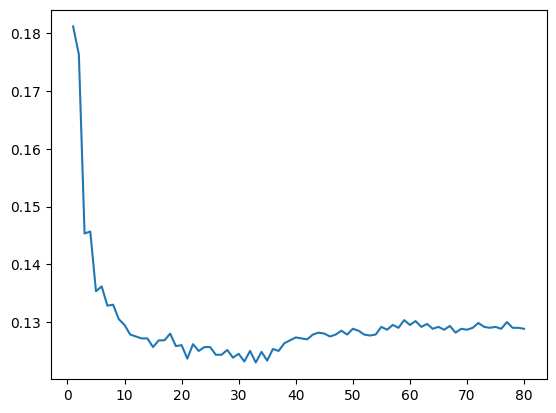

In [52]:
# D
from sklearn.metrics import mean_squared_error
from typing import Tuple

def test_error(X: np.ndarray, y: np.ndarray, clf):
    y_pred = clf.predict(X)
    err = mean_squared_error(y, y_pred)
    return err
def get_model_errs(
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        K_range: Tuple[int, int], 
        clf
    ):
    if K_range[0] >= K_range[1]:
        raise ValueError("Invalid range: K_range[0] should be less than K_range[1]")

    errs = []
    for k in np.arange(K_range[0], K_range[1]+1):
        print(f"Training model with k={k}/{K_range[1]}", end="\r")
        nei = clf(n_neighbors=k)
        nei.fit(X_train, y_train)
        errs.append(test_error(X_test, y_test, nei))
    return errs

df_test = pd.read_csv('Ex1-test.csv')
X_te = df_test[['x1', 'x2']].to_numpy()
y_te = df_test['y'].to_numpy()

Krange = (1, 80)
errs = get_model_errs(X_tr, y_tr, X_te, y_te, Krange, KNeighborsClassifier)

plt.plot(np.arange(Krange[0], Krange[1]+1), errs)
plt.show()
# low and high K bad, even K also bad cause ties and idk how the classifier handles that.
# anyway, K~21 seems pretty good, mby even 33, but that might be overfitting.

## Multiclass classification with multinomial logistic regression
For this exercise, continue with the two datasets Ex1-training.csv and Ex1-test.csv.

**Exercise 3.** The *softmax function* takes a *k*-dimensional vector of real numbers $\eta=(\eta_1,\dots,\eta_k)$ 
and returns a $k$-dimensional probability vector for the $k$ classes as
$$
\sigma(\eta_1,\dots,\eta_k)=\left(\frac{\mathrm{e}^{\eta_1}}{\sum_{i=1}^{k}\mathrm{e}^{\eta_{i}}},\dots,\frac{\mathrm{e}^{\eta_k}}{\sum_{i=1}^{k}\mathrm{e}^{\eta_{i}}}\right)
$$
Explain how multinomial logistic regression models posterior class probabilities via the softmax
function.


It does so by calculating the logistic regression posterior probability for every class, then normalising it with the summation term to get a total probability of 1. 
The probability for each class then represents how likely that class is compared to all other classes.

**Exercise 4.** Train a multinomial logistic regression and visualise its decision regions. It is up
to you how you want to include the features in the model (transformations? interaction term?)  
You can use `LogisticRegression` from `sklearn` specifying `multi_class="multinomial"` – see
page 150 in the Hands-on Machine Learning book, where they also excemplify how you can
first specify the model without the data, then pass the dataset of interest (test/training) to the
fitting method.

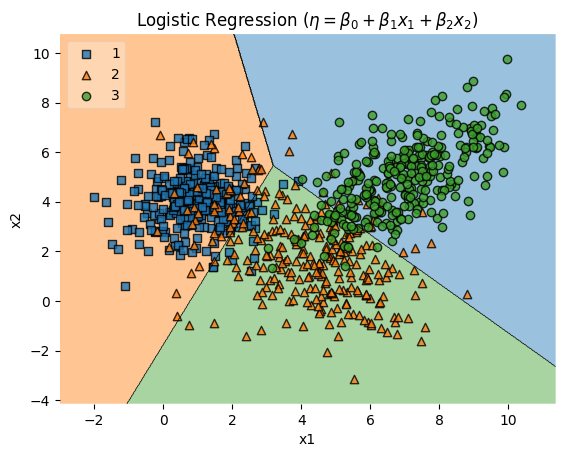

In [55]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class="multinomial").fit(X_tr, y_tr)

plot_decision_regions(X_tr, y_tr, clf=clf, legend=2, n_jobs=-1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Logistic Regression ($\eta=\\beta_0+\\beta_1x_1+\\beta_2x_2$)')
plt.show()
# im gonna kill myself